In [35]:
%cd /content/drive/My Drive/CODE/MSc_Dissertation/

/content/drive/My Drive/CODE/MSc_Dissertation


In [36]:
import torch
import math

from torch.nn import functional as F
import torch.utils.data as data

import numpy as np
from src.BatchBALD import repeated_mnist
import matplotlib.pyplot as plt

from sklearn.manifold import TSNE
import seaborn as sns

sns.set(rc={'figure.figsize':(8.7,6.27)})
palette = sns.color_palette("pastel", 10)
sns.set_style(style='white')

repeated = 1

train_dataset, test_dataset = repeated_mnist.create_repeated_MNIST_dataset(num_repetitions=repeated, add_noise=False)

In [37]:
np.squeeze(dataset[0][0],1).shape

(70000, 28, 28)

In [38]:
BatchBald = False

In [39]:
import numpy as np
import torch

import argparse
import pickle
import time

import src.Bayesian_coresets.acs.utils as utils
from src.Bayesian_coresets.acs.coresets import ProjectedFrankWolfe
from src.Bayesian_coresets.acs.al_data_set import Dataset, ActiveLearningDataset as ALD

from src.Bayesian_coresets.resnet.resnets import resnet18





## experiment
save_dir = './experiments/active_torchvision'
data_dir = './data'
seed = 222
init_num_labeled = 70
dataset = 'digits_mnist'
model_file = './models/best.pth.tar'

## optimization params
training_epochs = 150
initial_lr = 1e-3
freq_summary = 100
weight_decay = 5e-4
weight_decay_theta = 5e-4
inference = 'MF'
cov_rank = 2

## active learning params
budget = 10000
batch_size = 70
acq = 'Proj'
coreset = 'FW'
num_projections = 50
num_features = 256
gamma = 0
pretrained_model = False



##
utils.set_gpu_mode(True)
np.random.seed(seed)


torch.manual_seed(seed)
num_test_points = 10000
if dataset == 'fashion_mnist':
    from src.Bayesian_coresets.acs.al_data_set import mnist_train_transform as train_transform, mnist_test_transform as test_transform
elif dataset == 'digits_mnist':
    from src.Bayesian_coresets.acs.al_data_set import mnist_train_transform as train_transform, mnist_test_transform as test_transform
else:
    from src.Bayesian_coresets.acs.al_data_set import torchvision_train_transform as train_transform, torchvision_test_transform as test_transform
    if dataset == 'svhn':
        num_test_points = 26032

model = resnet18(pretrained=pretrained_model, pretrained_model_file=model_file, resnet_size=84)
model = utils.to_gpu(model)
dataset = utils.get_torchvision_dataset(
    name=dataset,
    data_dir=data_dir,
    model=model,
    encode=False,
    seed=seed,
    n_split=(-1, 10000, num_test_points)
)

In [40]:
if BatchBald:
    if repeated > 1:
        num_emb_data = 5000
        x = torch.empty((60000*repeated, 28*28))
        y = torch.empty((60000*repeated))
        for i in range(repeated):
            x[60000*i:60000*(i+1)] = train_dataset.datasets[i].data.reshape((60000,28*28))
            y[60000*i:60000*(i+1)] = train_dataset.datasets[i].targets
        train_data = x.clone()
        train_y = y.clone()
        x = x[0:num_emb_data]

        # y = train_dataset.targets
        y = y[0:num_emb_data]
    else: 
        num_emb_data = 5000

        x = train_dataset.data
        x = x.reshape((60000,28*28))[0:num_emb_data]

        y = train_dataset.targets
        y = y[0:num_emb_data]
else:
    dataset[0][0].shape
    num_emb_data = 5000

    x = dataset[0][0][:60000]

    x = torch.tensor(x.reshape((60000,28*28)))
    train_data = torch.tensor(x.clone())
    x = x[0:num_emb_data]

    y = torch.tensor(dataset[0][1][:60000]).squeeze()
    train_y = torch.tensor(y.clone())
    y = y[0:num_emb_data]

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


In [41]:
# num_emb_data = 5000

# x = train_dataset.data
# x = x.reshape((60000,28*28))[0:num_emb_data]

# y = train_dataset.targets
# y = y[0:num_emb_data]

In [42]:
def train_tsne(index):
    if BatchBald:
        if repeated > 1:
            new_x = torch.cat((x, train_data[index].reshape(len(index),28*28)), dim=0)
            new_y = torch.cat((y.int(), torch.tensor([10]*len(index)).int()))
            tsne = TSNE()
            X_embedded = tsne.fit_transform(new_x)    
        else:
            new_x = torch.cat((x, train_dataset.data[index].reshape(len(index),28*28)), dim=0)
            new_y = torch.cat((y, torch.tensor([10]*len(index))))
            tsne = TSNE()
            X_embedded = tsne.fit_transform(new_x)   
    else:
        new_x = torch.cat((x, train_data[index]), dim=0)
        new_y = torch.cat((y, torch.tensor([10]*len(index))))
        tsne = TSNE()
        X_embedded = tsne.fit_transform(new_x)   
    return X_embedded, new_y

In [43]:
y.shape

torch.Size([5000])

In [47]:
X_embedded, new_y = train_tsne(SSA_Neural_Linear)

# Starting from 300 data (strong predictive power 92% accuracy)

## BASELINE: acquire 1 data at a time, total of 70 data

In [ ]:
BALD_BASE_init_300 = [43852, 12935, 14125, 14367,  4822, 31335, 42383,  8130, 19942,
       47844, 50461, 22531, 40046, 28512, 47260,  2765, 11645, 36884,
       28362, 57956, 32047, 27972, 30418, 52358, 29132, 20217, 34445,
       17129, 58470,  3791, 35401, 39668, 35946,  5842, 47513,  5129,
       19995, 38698,  5659,  7168, 35971,  4784, 31301, 39818, 24479,
         224, 34743, 36852,  7768, 31738, 35482,  3810, 42121, 43897,
       43126,  3676, 49525, 26358,  1642, 37048, 57718, 52582,  1674,
        8691, 24278,  6418, 31941, 17486, 53873, 51464]

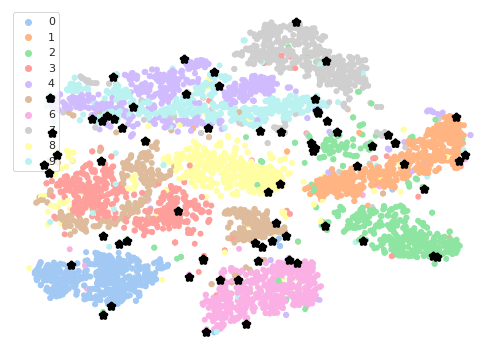

In [ ]:
fig, ax = plt.subplots()
test = sns.scatterplot(-BALD_X_embedded[0:5000,0], BALD_X_embedded[0:5000,1], hue=BALD_new_y[0:5000], legend='full', palette=palette, edgecolor="none")
ax2 = ax.twinx()
sns.scatterplot(-BALD_X_embedded[5000:,0], BALD_X_embedded[5000:,1], legend='full', linewidth=4, color = "b", edgecolor="black",marker = "*")
ax.axes.get_xaxis().set_visible(False)   
ax.axes.get_yaxis().set_visible(False)
ax2.axes.get_xaxis().set_visible(False)  
ax2.axes.get_yaxis().set_visible(False)
sns.despine(bottom = True, left = True)

## BALD

### acquire 15 data at a time, total of 15 data

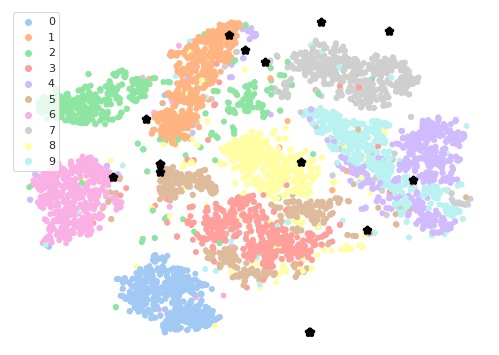

In [ ]:
fig, ax = plt.subplots()
test = sns.scatterplot(-X_embedded[0:5000,0], X_embedded[0:5000,1], hue=new_y[0:5000], legend='full', palette=palette, edgecolor="none")
ax2 = ax.twinx()
sns.scatterplot(-X_embedded[5000:,0], X_embedded[5000:,1], legend='full', linewidth=4, color = "b", edgecolor="black",marker = "*")
ax.axes.get_xaxis().set_visible(False)   
ax.axes.get_yaxis().set_visible(False)
ax2.axes.get_xaxis().set_visible(False)  
ax2.axes.get_yaxis().set_visible(False)
sns.despine(bottom = True, left = True)

### acquire 70 data at a time, total of 70 data

In [ ]:
BALD_extreme_init_300 = [ 1374, 52121, 47230, 11708, 20853, 37407, 33222, 48098, 19590,
        37974, 55388, 48096, 37373, 25309, 19466, 41900, 23463, 12345,
        23350, 56664, 14329, 31558,  8435,  1024, 28525, 54350, 19148,
        25910, 52550, 14665, 14043,  5474, 48944, 49895, 16210, 47844,
        36834, 22376, 22783, 24740, 27225, 20710, 10400, 44267, 24485,
         6983,  9118, 22497, 50370, 14817, 27915, 50625, 13253, 41108,
        20171, 24632, 15462, 51180,  8833, 37383, 42515, 38577, 19524,
        38488,  4315, 22053, 30478, 49893, 49590, 33469]

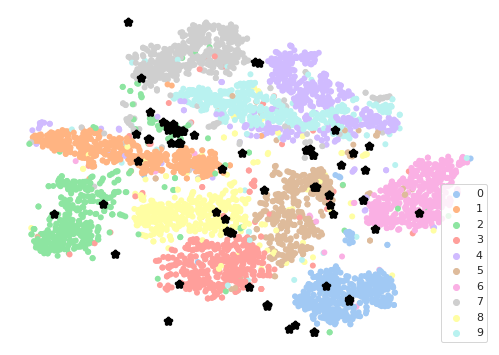

In [ ]:
fig, ax = plt.subplots()
test = sns.scatterplot(-BALD_X_embedded[0:5000,0], BALD_X_embedded[0:5000,1], hue=BALD_new_y[0:5000], legend='full', palette=palette, edgecolor="none")
ax2 = ax.twinx()
sns.scatterplot(-BALD_X_embedded[5000:,0], BALD_X_embedded[5000:,1], legend='full', linewidth=4, color = "b", edgecolor="black",marker = "*")
ax.axes.get_xaxis().set_visible(False)   
ax.axes.get_yaxis().set_visible(False)
ax2.axes.get_xaxis().set_visible(False)  
ax2.axes.get_yaxis().set_visible(False)
sns.despine(bottom = True, left = True)

## BatchBALD

### acquire 15 data at a time, total of 15 data

In [ ]:
BatchBALD_extreme_init_300 = [32126, 23112, 47016, 54077, 24623, 29212, 24103, 33228, 51992,
        21115, 14682, 17848, 30258, 45621, 36441]

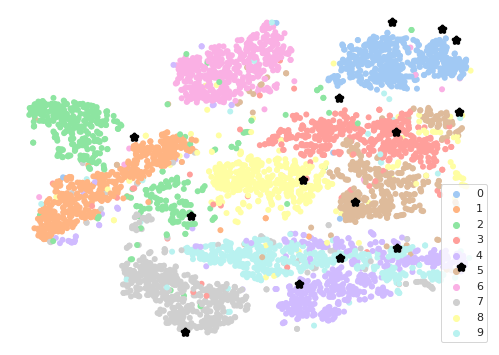

In [ ]:
fig, ax = plt.subplots()
test = sns.scatterplot(-X_embedded[0:5000,0], X_embedded[0:5000,1], hue=new_y[0:5000], legend='full', palette=palette, edgecolor="none")
ax2 = ax.twinx()
sns.scatterplot(-X_embedded[5000:,0], X_embedded[5000:,1], legend='full', linewidth=4, color = "b", edgecolor="black",marker = "*")
ax.axes.get_xaxis().set_visible(False)   
ax.axes.get_yaxis().set_visible(False)
ax2.axes.get_xaxis().set_visible(False)  
ax2.axes.get_yaxis().set_visible(False)
sns.despine(bottom = True, left = True)

# Starting from 20 data (low prediction power 60-70% accuracy)

## BASELINE: acquire 1 data at a time, total of 70 data

In [ ]:
BALD_BASE_init_20 = [52862, 35962, 58821, 54709, 13658, 16047, 37769, 59446, 59418,
       21963, 25509,  7033, 21197, 20100, 18007, 34829, 14121, 17870,
       45686, 10265,  4646, 57510, 35018,  4606, 34815, 32022, 38256,
       16692, 59014, 39151, 38512, 55513, 48952, 42141, 12345, 33776,
       25654, 56184, 54880, 51986, 23642, 57736, 33812, 29132, 44101,
       42573, 49537, 13781, 20820, 20025,  7924, 25301,  6145, 39425,
       10070, 22083, 37974, 46878, 37048, 37214, 27328, 19612, 11693,
       40752, 42415,  7168,  1239, 39480, 11613, 33222]

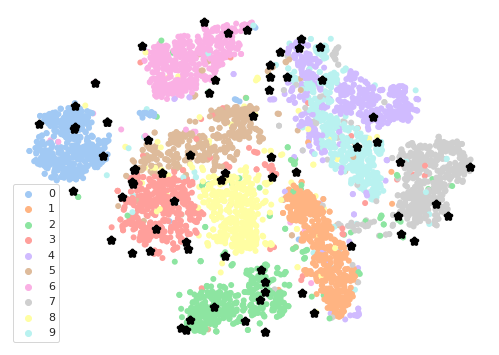

In [ ]:
fig, ax = plt.subplots()
test = sns.scatterplot(-X_embedded[0:5000,0], X_embedded[0:5000,1], hue=new_y[0:5000], legend='full', palette=palette, edgecolor="none")
ax2 = ax.twinx()
sns.scatterplot(-X_embedded[5000:,0], X_embedded[5000:,1], legend='full', linewidth=4, color = "b", edgecolor="black",marker = "*")
ax.axes.get_xaxis().set_visible(False)   
ax.axes.get_yaxis().set_visible(False)
ax2.axes.get_xaxis().set_visible(False)  
ax2.axes.get_yaxis().set_visible(False)
sns.despine(bottom = True, left = True)

### BALD: acquire 70 data at a time, total of 70 data

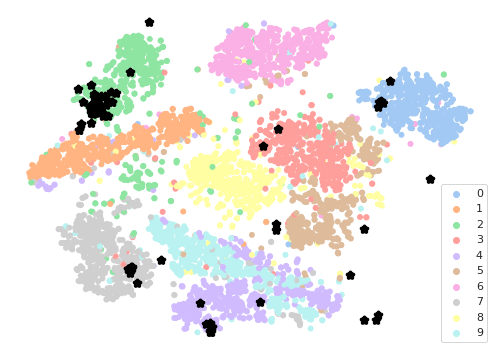

In [ ]:
fig, ax = plt.subplots()
test = sns.scatterplot(-BALD_X_embedded[0:5000,0], BALD_X_embedded[0:5000,1], hue=BALD_new_y[0:5000], legend='full', palette=palette, edgecolor="none")
ax2 = ax.twinx()
sns.scatterplot(-BALD_X_embedded[5000:,0], BALD_X_embedded[5000:,1], legend='full', linewidth=4, color = "b", edgecolor="black",marker = "*")
ax.axes.get_xaxis().set_visible(False)   
ax.axes.get_yaxis().set_visible(False)
ax2.axes.get_xaxis().set_visible(False)  
ax2.axes.get_yaxis().set_visible(False)
sns.despine(bottom = True, left = True)

### BatchBALD: acquire 50 data at a time, total of 50 data

In [ ]:
BatchBALD_extreme_init_20 = [12906, 47912, 21255 ,12813 ,14143 ,16600 ,24419, 21200 ,32353 ,44001, 57349 ,39823,
 46228,  9181, 38570 ,18238 ,20017 ,26492 , 5507 ,49284 , 5989 ,55231, 44511 , 8602,
  5503, 39898, 41993 ,52297 ,31082 ,35739 ,40749, 17650 ,46763 ,54872, 11666 ,16955,
 33188, 31081, 48651 ,12075 ,12020 ,49791 , 3602, 38159 ,36203 ,58219,  8574 ,25380,
 24013, 37349]

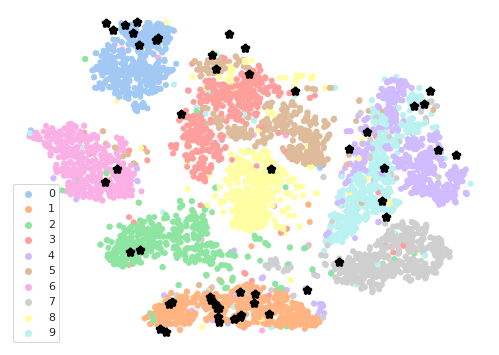

In [ ]:
fig, ax = plt.subplots()
test = sns.scatterplot(-X_embedded[0:5000,0], X_embedded[0:5000,1], hue=new_y[0:5000], legend='full', palette=palette, edgecolor="none")
ax2 = ax.twinx()
sns.scatterplot(-X_embedded[5000:,0], X_embedded[5000:,1], legend='full', linewidth=4, color = "b", edgecolor="black",marker = "*")
ax.axes.get_xaxis().set_visible(False)   
ax.axes.get_yaxis().set_visible(False)
ax2.axes.get_xaxis().set_visible(False)  
ax2.axes.get_yaxis().set_visible(False)
sns.despine(bottom = True, left = True)

### SPARSE SUBSET APPROXIMATION: acquire 70 data at a time, total of 70 data

In [ ]:
FW = [  182,   328,  3429,  3945  ,4909 , 5352 , 7873,  9160  ,9745  ,9936 ,11695, 11707,
 13388, 14453, 17353 ,19560, 20818 ,22161, 22322, 22337, 23059 ,25042 ,25286, 25290,
 25527, 26799, 26810 ,27243 ,27373 ,27808, 27897, 27898, 29357 ,29414 ,30183, 30595,
 32210, 32655, 34098 ,34326 ,35194 ,37187, 37228, 37447, 37842 ,37856 ,41679, 42169,
 42449, 42893, 43564 ,44058 ,46146 ,47009, 47470 ,49310]

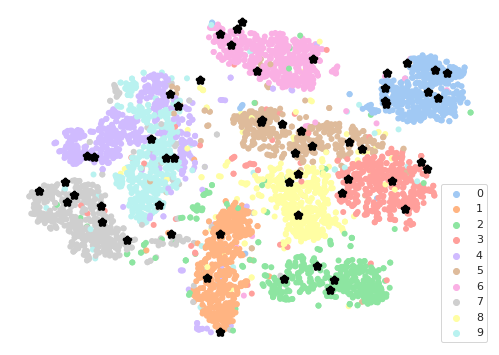

In [ ]:
fig, ax = plt.subplots()
test = sns.scatterplot(-X_embedded[0:5000,0], X_embedded[0:5000,1], hue=new_y[0:5000], legend='full', palette=palette, edgecolor="none")
ax2 = ax.twinx()
sns.scatterplot(-X_embedded[5000:,0], X_embedded[5000:,1], legend='full', linewidth=4, color = "b", edgecolor="black",marker = "*")
ax.axes.get_xaxis().set_visible(False)   
ax.axes.get_yaxis().set_visible(False)
ax2.axes.get_xaxis().set_visible(False)  
ax2.axes.get_yaxis().set_visible(False)
sns.despine(bottom = True, left = True)

# Repeated MNIST

## BASELINE: acquire 1 data at a time, total of 70 data

In [ ]:
BALD_R_MNIST_BASE_init_20 = [18135, 45098, 36950, 54461, 19759, 8417, 49784, 7949, 31327, 30417, 4541, 19824, 17491, 9000, 23216, 34594, 32510, 44040, 38256, 27267, 21395, 16860, 23468, 54534, 10210, 5842, 51415, 46923, 7833, 38332, 59390, 49537, 13119, 1812, 59468, 21385, 47181, 46808, 19089, 28398, 34815, 23104, 3791, 4767, 20172, 46329, 44882, 33364, 14623, 45917, 45046, 22272, 13350, 30495, 8736, 38319, 35654, 39409, 12037, 6755, 15848, 37070, 17756, 32065, 12663, 9770, 43176, 8799, 16756, 44267 ]

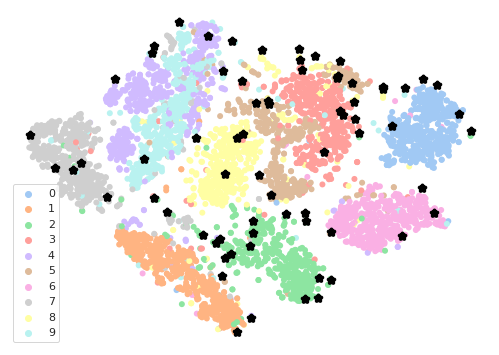

In [ ]:
fig, ax = plt.subplots()
test = sns.scatterplot(-X_embedded[0:5000,0], X_embedded[0:5000,1], hue=new_y[0:5000], legend='full', palette=palette, edgecolor="none")
ax2 = ax.twinx()
sns.scatterplot(-X_embedded[5000:,0], X_embedded[5000:,1], legend='full', linewidth=4, color = "b", edgecolor="black",marker = "*")
ax.axes.get_xaxis().set_visible(False)   
ax.axes.get_yaxis().set_visible(False)
ax2.axes.get_xaxis().set_visible(False)  
ax2.axes.get_yaxis().set_visible(False)
sns.despine(bottom = True, left = True)

### BALD: acquire 70 data at a time, total of 70 data

In [ ]:
BALD_R_MNIST_init_20 = [136550,  76550,  16550, 106716,  46716, 166716, 161239, 101239,
         41239,  99947,  39947, 159947, 118226, 178226,  58226,  76249,
        136249,  16249, 128415,  68415,   8415, 159963,  39963,  99963,
         65217,   5217, 125217,  81461,  21461, 141461, 127768,  67768,
          7768, 132425,  72425,  12425, 127674,  67674,   7674,  12525,
         72525, 132525,  49824, 169824, 109824,  18674, 138674,  78674,
        132933,  72933,  12933, 139840,  79840,  19840, 153461,  33461,
         93461, 121213,  61213,   1213,  16947, 136947,  76947, 160135,
        100135,  40135,  62633,   2633, 122633,  77045]

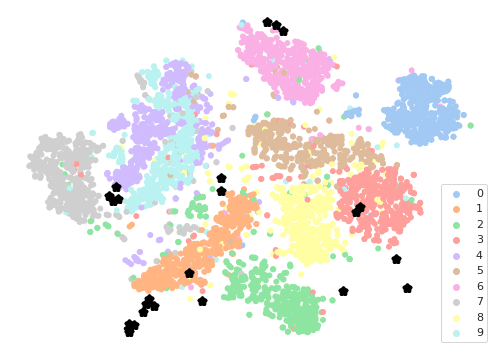

In [ ]:
fig, ax = plt.subplots()
test = sns.scatterplot(-X_embedded[0:5000,0], X_embedded[0:5000,1], hue=new_y[0:5000], legend='full', palette=palette, edgecolor="none")
ax2 = ax.twinx()
sns.scatterplot(-X_embedded[5000:,0], X_embedded[5000:,1], legend='full', linewidth=4, color = "b", edgecolor="black",marker = "*")
ax.axes.get_xaxis().set_visible(False)   
ax.axes.get_yaxis().set_visible(False)
ax2.axes.get_xaxis().set_visible(False)  
ax2.axes.get_yaxis().set_visible(False)
sns.despine(bottom = True, left = True)

In [ ]:
BALD_Neural_Linear = [11185, 33232, 18546, 20688, 38600, 41529, 5658, 24200, 11435, 25776, 45997, 5228, 38005, 35885, 20755, 38731, 26214, 4158, 19962, 12111, 26936, 27639, 13448, 5753, 5389, 47452, 15294, 49837, 18758, 11106, 26130, 32436, 28643, 6668, 41342, 43433, 8835, 9431, 26079, 45961, 46645, 36506, 16484, 22040, 45668, 1792, 13520, 23705, 4204, 36258, 29612, 24210, 24497, 32995, 30372, 19398, 31996, 45542, 28450, 39255, 14882, 47898, 17914, 46373, 46796, 45964, 42292, 37008, 36372, 5611, 44937, 30862, 15226, 31609, 43829, 36013, 45077, 48010, 16042, 16798, 41709, 47218, 36962, 350, 14464, 7530, 46313, 3669, 577, 6240, 1039, 4478, 3826, 38540, 19621, 40930, 13613, 8207, 25179, 12820]
BALD_Neural_Linear_2 = [41358, 10283, 5972, 10203, 1963, 4201, 10259, 25321, 46944, 25285, 42832, 14692, 26100, 31030, 47634, 37189, 41904, 25291, 37141, 10233, 6066, 37198, 48371, 42247, 10217, 17602, 46344, 40034, 15158, 24641, 15282, 37183, 29048, 23386, 10261, 25297, 25493, 25305, 5380, 10207, 21851, 1199, 37946, 10245, 8453, 29391, 36147, 10317, 39463, 12716, 27293, 756, 42669, 9985, 39385, 22949, 22583, 41556, 4488, 23123, 42335, 7915, 21192, 48059, 10237, 26946, 14101, 46338, 10279, 36149, 14075, 36159, 25018, 13545, 32548, 1371, 10269, 24722, 23273, 10271, 29341, 47558, 16676, 25325, 44934, 8489, 37263, 3338, 10936, 26602, 5475, 1247, 5973, 22939, 1397, 11998, 43834, 1466, 47655, 3928]
BALD_Neural_Linear_3 = [22124, 44732, 657, 5052, 19714, 45617, 28920, 48929, 27599, 11273, 37507, 36529, 33450, 27286, 41516, 21450, 36446, 45181, 43518, 1974, 48285, 27928, 44927, 47597, 18000, 25415, 39923, 17591, 12784, 27090, 11659, 25362, 14191, 46482, 10502, 13747, 42990, 12709, 34919, 37315, 2676, 29392, 20728, 45238, 38383, 25159, 41045, 32344, 35086, 33401, 7851, 22471, 32309, 33102, 25480, 20676, 8468, 6305, 27180, 614, 32471, 37379, 38514, 16952, 11171, 4017, 34542, 40198, 33697, 7450, 29759, 14626, 19616, 42373, 24497, 42948, 14329, 17648, 19396, 39706, 45543, 21198, 12232, 7412, 2803, 24473, 48190, 33438, 49106, 16918, 48102, 38439, 46056, 13946, 6466, 7034, 488, 3108, 30972, 16826]

In [46]:
SSA_Neural_Linear = [6186, 47756, 23277, 49295, 5993, 2526, 15104, 33633, 22188, 9281, 17137, 7468, 15213, 28140, 20213, 17366, 5033, 48337, 6284, 48367, 8489, 18, 28781, 38153, 41578, 23956, 12063, 13365, 18276, 16275, 2118, 32317, 40343, 45471, 30369, 47822, 13570, 10936, 35599, 19571, 707, 15119, 14973, 24998, 13126, 8084, 18644, 17577, 18803, 15734, 11027, 49967, 46851, 3052, 9417, 38951, 48046, 41653, 19257, 29351, 20485, 27450, 10756, 33957, 6307, 21789, 7013, 36629, 47064, 34082, 2793, 38799, 16607, 15039, 1969, 48866, 4022, 10259, 10825, 40569, 45880, 26195, 22078, 7328, 15312, 23156, 42141, 20882, 41969, 36593, 3319, 28021, 31879, 7915, 46636, 8531]

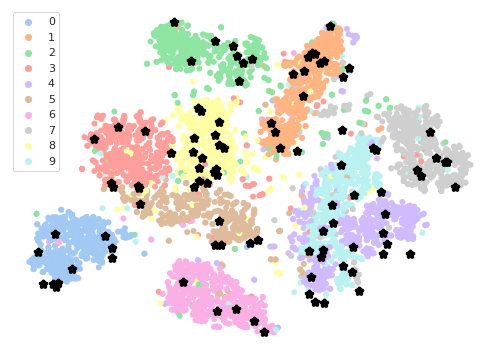

In [ ]:
fig, ax = plt.subplots()
test = sns.scatterplot(-X_embedded[0:5000,0], X_embedded[0:5000,1], hue=new_y[0:5000], legend='full', palette=palette, edgecolor="none")
ax2 = ax.twinx()
sns.scatterplot(-X_embedded[5000:,0], X_embedded[5000:,1], legend='full', linewidth=4, color = "b", edgecolor="black",marker = "*")
ax.axes.get_xaxis().set_visible(False)   
ax.axes.get_yaxis().set_visible(False)
ax2.axes.get_xaxis().set_visible(False)  
ax2.axes.get_yaxis().set_visible(False)
sns.despine(bottom = True, left = True)

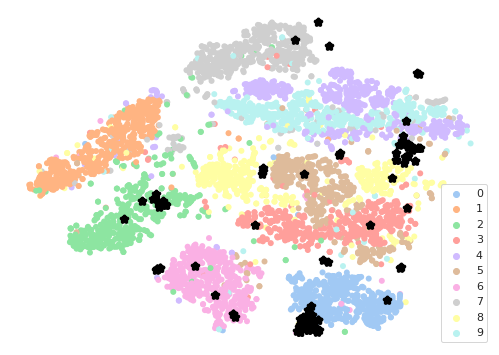

In [ ]:
fig, ax = plt.subplots()
test = sns.scatterplot(-X_embedded[0:5000,0], X_embedded[0:5000,1], hue=new_y[0:5000], legend='full', palette=palette, edgecolor="none")
ax2 = ax.twinx()
sns.scatterplot(-X_embedded[5000:,0], X_embedded[5000:,1], legend='full', linewidth=4, color = "b", edgecolor="black",marker = "*")
ax.axes.get_xaxis().set_visible(False)   
ax.axes.get_yaxis().set_visible(False)
ax2.axes.get_xaxis().set_visible(False)  
ax2.axes.get_yaxis().set_visible(False)
sns.despine(bottom = True, left = True)

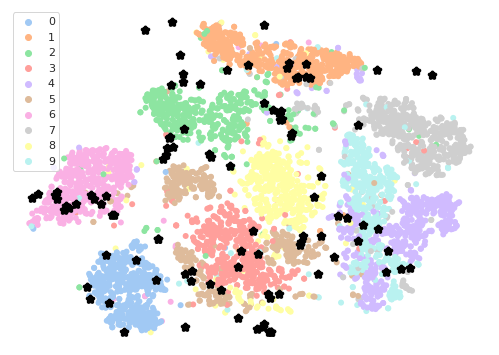

In [ ]:
fig, ax = plt.subplots()
test = sns.scatterplot(-X_embedded[0:5000,0], X_embedded[0:5000,1], hue=new_y[0:5000], legend='full', palette=palette, edgecolor="none")
ax2 = ax.twinx()
sns.scatterplot(-X_embedded[5000:,0], X_embedded[5000:,1], legend='full', linewidth=4, color = "b", edgecolor="black",marker = "*")
ax.axes.get_xaxis().set_visible(False)   
ax.axes.get_yaxis().set_visible(False)
ax2.axes.get_xaxis().set_visible(False)  
ax2.axes.get_yaxis().set_visible(False)
sns.despine(bottom = True, left = True)